# Hyperparameter Tuning
## Notebook Setup

In [ ]:
import os
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
os.chdir(os.path.join("/", "home", "walkerdavis", "projects", "mpsc"))
DATA_ROOT = os.path.join("data", "processed")

## Dataset Loading and Splitting

In [6]:
df = pd.read_csv(os.path.join(DATA_ROOT, "Consolidated.csv"))

df = df.dropna(subset=["WeeklyWeightGainGPerKGPerDay"])

In [44]:
X = df.drop(
    columns=[
        "WeeklyWeightGainGPerDay",
        "WeeklyWeightGainGPerKGPerDay",
        "DailyWeightGainGPerDay",
        "DailyWeightGainGPerKGPerDay",
    ]
)
y = df["WeeklyWeightGainGPerKGPerDay"]

for col in X.select_dtypes(include=["object", "category"]).columns:
    X[col] = X[col].fillna("Missing")
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

for col in X.select_dtypes(include=["float64", "int64"]).columns:
    X[col] = X[col].fillna(X[col].median())

X = X.clip(lower=-1e6, upper=1e6)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
def model_results(preds, y_test):
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    return f"MAE: {mae} | MSE: {mse} | r^2: {r2}"

## Quicktuning with Grid Search

In [27]:
param_grid: dict[str, Union[list[int], list[float]]] = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "gamma": [0, 1, 5],
}

model = xg.XGBRegressor(objective="reg:squarederror", seed=42)
"""
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=1,
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score (negative MSE):", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print(model_results(preds=y_pred, y_test=y_test))
"""

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=128,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=1,
)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV score (negative MSE):", random_search.best_score_)

y_pred = random_search.predict(X_test)
print(model_results(preds=y_pred, y_test=y_test))

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.1, max_

In [28]:
importances = pd.Series(
    random_search.best_estimator_.feature_importances_, index=X_train.columns
).sort_values(ascending=False)
importances.head(29)

BW_sqrt                                          0.121795
DailyEnergyParenteralPerKG_sqrt                  0.055318
DailyFluidOutputPerKG_squared_squared            0.035705
MeanDailyPulse_sqrt                              0.032620
SmoothedWeightG_squared                          0.028778
DailyFluidIntake_rolling_mean_sqrt               0.027578
BW                                               0.025227
SmoothedWeightG_sqrt_squared                     0.023635
MeanDailyDiastolicBP                             0.022812
GA_squared                                       0.022600
DailyFluidIntakePerKG_squared_squared            0.020783
DailyFluidIntake_rolling_mean_squared_squared    0.020406
PMADays                                          0.018622
DailyFluidOutput_rolling_mean_squared            0.018129
MeanDailyResp_sqrt                               0.016504
DailyEnergyPerKG_squared_squared                 0.016407
DailyEnergy_sqrt                                 0.016106
DayFromBirthNu

In [30]:
X_test

,ID,DOB,GA,BW,Sex,StartDate,DailyEnergyEnteral,DailyEnergyParenteral,DailyEnergy,MeanDailyPulse,...,DailyFluidOutputPerKG_sqrt_squared,DailyFluidOutputPerKG_sqrt_sqrt,DailyFluidOutput_rolling_mean_squared_squared,DailyFluidOutput_rolling_mean_squared_sqrt,DailyFluidOutput_rolling_mean_sqrt_squared,DailyFluidOutput_rolling_mean_sqrt_sqrt,DailyFluidOutput_rolling_std_squared_squared,DailyFluidOutput_rolling_std_squared_sqrt,DailyFluidOutput_rolling_std_sqrt_squared,DailyFluidOutput_rolling_std_sqrt_sqrt
6656,423,2,37.0,3120,1,165,111.59,0.00,111.59,140.000000,...,70.901243,2.901773,1000000.0,241.675000,241.675000,3.942829,262986.916506,22.645585,22.645585,2.181453
2016,113,1,28.0,1206,1,89,194.80,0.00,194.80,163.333333,...,89.082718,3.072192,1000000.0,174.000000,174.000000,3.631929,177241.000000,20.518285,20.518285,2.128312
4618,290,2,29.0,1280,1,162,6.11,116.94,123.05,169.750000,...,81.503496,3.004651,1000000.0,97.000000,97.000000,3.138289,1000000.000000,39.211125,39.211125,2.502375
5208,322,2,37.0,4040,1,174,439.56,0.00,439.56,175.500000,...,125.983898,3.350262,1000000.0,348.500000,348.500000,4.320666,1000000.000000,142.687315,142.687315,3.456180
5688,348,2,33.0,2350,1,180,243.48,0.00,243.48,158.300000,...,106.778275,3.214554,1000000.0,239.185714,239.185714,3.932637,1000000.000000,53.068585,53.068585,2.699040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,257,2,29.0,1055,1,221,324.64,0.00,324.64,173.100000,...,90.180722,3.081615,1000000.0,253.857143,253.857143,3.991603,341612.417234,24.175942,24.175942,2.217409
2654,164,1,24.0,800,1,140,357.04,0.00,357.04,154.500000,...,80.878005,2.998870,1000000.0,264.071429,264.071429,4.031163,1000000.000000,58.225444,58.225444,2.762347
4239,267,2,35.0,2807,1,168,357.07,0.00,357.07,150.833333,...,106.571745,3.212998,1000000.0,306.171429,306.171429,4.183032,1000000.000000,39.256495,39.256495,2.503098
5987,368,2,28.0,1180,1,182,181.76,0.00,181.76,151.800000,...,62.601168,2.812844,1000000.0,112.928571,112.928571,3.259875,8409.326672,9.576136,9.576136,1.759129


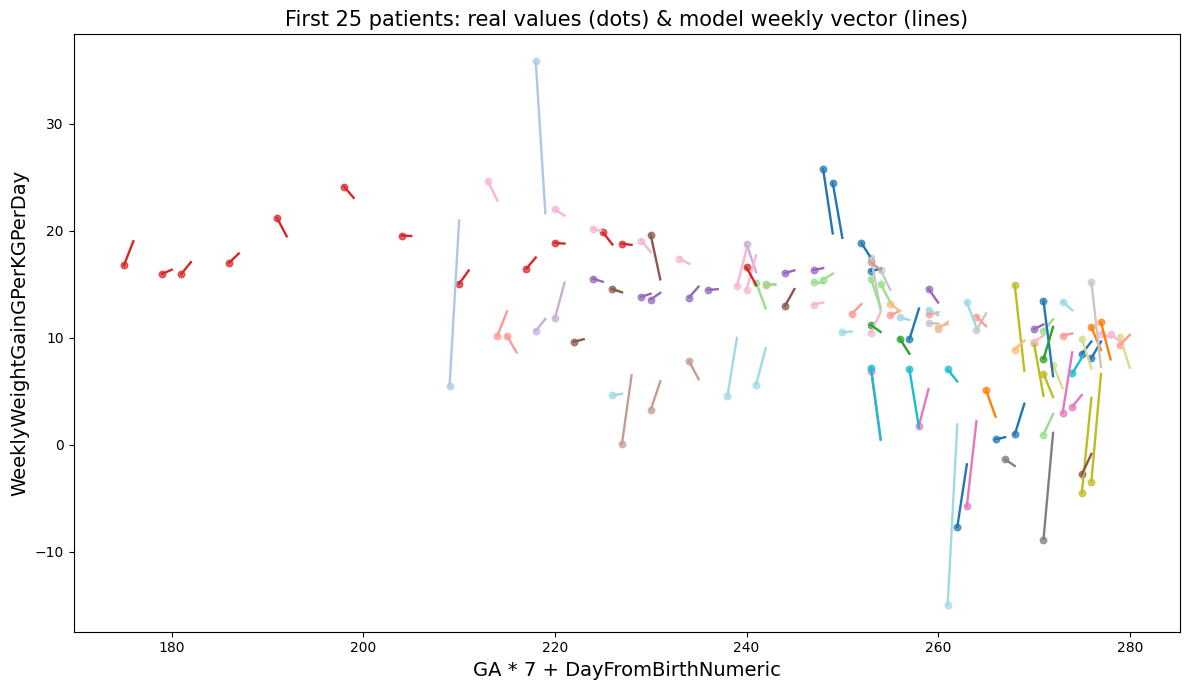

In [ ]:
df = X_test.copy()
df["WeeklyWeightGainPerKgPerDay"] = y_test
df["GA * 7 + DayFromBirthNumeric"] = df["GA"] * 7 + df["DayFromBirthNumeric"]

n_patients = 25
patient_ids = df["ID"].unique()[:n_patients]
df_subset = df[df["ID"].isin(patient_ids)]

fig, ax = plt.subplots(figsize=(12, 7))
color_cycle = plt.cm.tab20(np.linspace(0, 1, n_patients))
patient_colors = {pid: color_cycle[i] for i, pid in enumerate(patient_ids)}


for patient_id, group in df_subset.groupby("ID"):
    color = patient_colors[patient_id]

    x_vals = group["GA * 7 + DayFromBirthNumeric"].values
    y_real = group["WeeklyWeightGainPerKgPerDay"].values

    model_X = X_test.loc[group.index]
    y_pred = random_search.predict(model_X)

    ax.scatter(x_vals, y_real, s=22, alpha=0.7, color=color)

    for i in range(len(x_vals)):
        x_head = x_vals[i]
        y_head = y_real[i]
        pred_gain = y_pred[i]

        x_tail = x_head + 7
        y_tail = y_head + pred_gain * 7

        ax.plot([x_head, x_tail], [y_head, y_tail], color=color, linewidth=1.7)

ax.set_xlabel("GA * 7 + DayFromBirthNumeric", fontsize=14)
ax.set_ylabel("WeeklyWeightGainGPerKGPerDay", fontsize=14)
ax.set_title(f"First {n_patients} patients: real values (dots) & model weekly vector (lines)", fontsize=15)
plt.tight_layout()
plt.show()


## Hyperparam Tuning with Optuna

In [22]:
def objective_func(trial: optuna.Trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 32)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0, 1)
    objective = trial.suggest_categorical(
        "objective",
        [
            "reg:squarederror",
            "reg:absoluteerror",
        ],
    )
    learning_rate = trial.suggest_float("learning_rate", 0.005, 0.25)

    model = xg.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        objective=objective,
        learning_rate=learning_rate,
        random_state=42,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = r2_score(y_test, y_pred)

    return score


study = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42)
)
study.optimize(objective_func, n_trials=1000)

print("Best Trial")
trial = study.best_trial

print(f"Value: {trial.value}")

print("Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-17 08:44:09,904] A new study created in memory with name: no-name-fa29308d-a8d2-449c-9635-325443de369a
[I 2025-07-17 08:44:24,868] Trial 0 finished with value: 0.4932490813725503 and parameters: {'n_estimators': 437, 'max_depth': 48, 'min_child_weight': 24, 'colsample_bytree': 0.5986584841970366, 'objective': 'reg:squarederror', 'learning_rate': 0.019230484981208867}. Best is trial 0 with value: 0.4932490813725503.
[I 2025-07-17 08:44:42,763] Trial 1 finished with value: 0.3833568090115923 and parameters: {'n_estimators': 880, 'max_depth': 34, 'min_child_weight': 23, 'colsample_bytree': 0.020584494295802447, 'objective': 'reg:squarederror', 'learning_rate': 0.057023082116177654}. Best is trial 0 with value: 0.4932490813725503.
[I 2025-07-17 08:44:49,372] Trial 2 finished with value: 0.5269831450152953 and parameters: {'n_estimators': 263, 'max_depth': 17, 'min_child_weight': 10, 'colsample_bytree': 0.5247564316322378, 'objective': 'reg:squarederror', 'learning_rate': 0.15490

Best Trial
Value: 0.637264985933534
Params:
    n_estimators: 310
    max_depth: 11
    min_child_weight: 1
    colsample_bytree: 0.9877223897360315
    objective: reg:squarederror
    learning_rate: 0.17151358425980212


In [ ]:
best_params = study.best_params

best_n_estimators = best_params["n_estimators"]
best_max_depth = best_params["max_depth"]
best_min_child_weight = best_params["min_child_weight"]
best_colsample_bytree = best_params["colsample_bytree"]
best_objective = best_params["objective"]
best_learning_rate = best_params["learning_rate"]

best_model = xg.XGBRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    colsample_bytree=best_colsample_bytree,
    objective=best_objective,
    learning_rate=best_learning_rate,
)

best_model.fit(X_train, y_train)

y_pred_xgb_optuna_200_trials = best_model.predict(X_test)

model_results(y_pred_xgb_optuna_200_trials, y_test)

MAE: 2.831387331460588 | MSE: 48.71796382861781 | r^2: 0.6107241278870943
